# Predicting Monthly Industry-wide Nuclear Power Plant Power Output

## Problem Statement

This model will predict the average monthly expected power output across the U.S. Nuclear Industry based on the number of NRC-related reports issued that month.  The NRC issues reports which categorize performance deficiences, at a high level, as Green or Greater-than-Green (GTG).  Additionally, the Nuclear Power Plants have a regulatory obligation to submit Event Notifications (ENs) and Licensee Event Reports (LERs) depending on the deficiency that occurs at their plant.  Depending on the severity of the deficiency, the power output of a plant may decrease or even go down to 0.  

This model with provide insight on the effectiveness of these reports to predict power level changes.

## Importing Appropriate Libraries and Data

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

### This data was cleaned and developed from several other excel files. 

I cleaned the data in those files and developed functions to obtain counts and averages between the years 2006-2019.  The data was evaluated using methods similar to those done below and were checked for nulls.  I used slight variations of this function to extract the numbers per month of each data source and the monthly average power output:

def ENcounts(year):
    
    JanAvg = df[year+'-01-01':year+'-01-31'].ScramType1.count()
    FebAvg = df[year+'-02-01':year+'-02-28'].ScramType1.count()
    MarAvg = df[year+'-03-01':year+'-03-31'].ScramType1.count()
    AprAvg = df[year+'-04-01':year+'-04-30'].ScramType1.count()
    MayAvg = df[year+'-05-01':year+'-05-31'].ScramType1.count()
    JunAvg = df[year+'-06-01':year+'-06-30'].ScramType1.count()
    JulAvg = df[year+'-07-01':year+'-07-31'].ScramType1.count()
    AugAvg = df[year+'-08-01':year+'-08-31'].ScramType1.count()
    SepAvg = df[year+'-09-01':year+'-09-30'].ScramType1.count()
    OctAvg = df[year+'-10-01':year+'-10-31'].ScramType1.count()
    NovAvg = df[year+'-11-01':year+'-11-30'].ScramType1.count()
    DecAvg = df[year+'-12-01':year+'-12-31'].ScramType1.count()
    print('{} {} {} {} {} {} {} {} {} {} {} {}'.format(JanAvg, FebAvg, MarAvg, AprAvg, MayAvg, JunAvg, JulAvg, AugAvg, SepAvg, OctAvg, NovAvg, DecAvg))




## Approach Overview

I have previously cleaned and compiled data from 5 different datasources as described above and inputted the values into the excel spreadsheet read in below.  The datasources contain publicly available information and have been obtained from the NRC's data center.  

I will evaluate this data to see if any of the variables for LERs, ENs, GTGs, or Green contain any correlation to be identified as target variables.  Then I will run a linear regression and evaluate the output.  

## Exploratory Data Analysis

In [99]:
df = pd.read_excel('PowerStatusProjData.xlsx') #read into cleaned excel file


The variable Avg_Power is the average monthly power output across the entire nuclear fleet.
The variable LER is the number of Licensee Event Reports submitted that month.
The variable EN is the number of Event Notifications submitted that month.
The variable GTG is Greater-Than-Green findings issued that month.
The variable Green is Green findings issued that month.  

In [100]:
df.head()

,Year,Avg_Power,LER,EN,GTG,Green
0,2019-01-01,96.102000,10,25,0,2
1,2019-02-01,93.597000,10,12,0,6
2,2019-03-01,85.429974,21,29,0,82
3,2019-04-01,83.009524,18,32,0,7
4,2019-05-01,89.779460,23,33,0,6


In [101]:
df.shape

(168, 6)

168 values per each category correspond to the number of months from 2006-2019.  There are no null values.  The Year was imported as datetime and the rest are appropriately typed as float or int.

In [102]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 6 columns):
Year         168 non-null datetime64[ns]
Avg_Power    168 non-null float64
LER          168 non-null int64
EN           168 non-null int64
GTG          168 non-null int64
Green        168 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 8.0 KB


Summary statistics are provided below.  There is a range of 25% in the power output and the average power is 89.4%.  The average number of LERs per month are ~24 while the average for ENs is ~37.

In [103]:
df.describe()

,Avg_Power,LER,EN,GTG,Green
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,89.440357,24.315476,37.607143,1.017857,58.607143
std,6.517865,7.985121,12.765520,1.216027,61.235585
min,73.147546,7.000000,11.000000,0.000000,0.000000
25%,84.541667,18.000000,28.000000,0.000000,16.000000
50%,91.262144,24.000000,36.000000,1.000000,24.500000
75%,94.919231,30.000000,45.000000,2.000000,110.750000
max,98.825962,49.000000,79.000000,6.000000,215.000000


In [104]:
df.Avg_Power.max()-df.Avg_Power.min() #the range is ~25%

25.678415119363393

In [105]:
df = df.set_index(['Year'])
df

,Avg_Power,LER,EN,GTG,Green
Year,,,,,
2019-01-01,96.102000,10,25,0,2
2019-02-01,93.597000,10,12,0,6
2019-03-01,85.429974,21,29,0,82
2019-04-01,83.009524,18,32,0,7
2019-05-01,89.779460,23,33,0,6
...,...,...,...,...,...
2006-08-01,96.984936,22,38,6,14
2006-09-01,91.726459,17,20,0,108
2006-10-01,76.092628,40,54,1,22


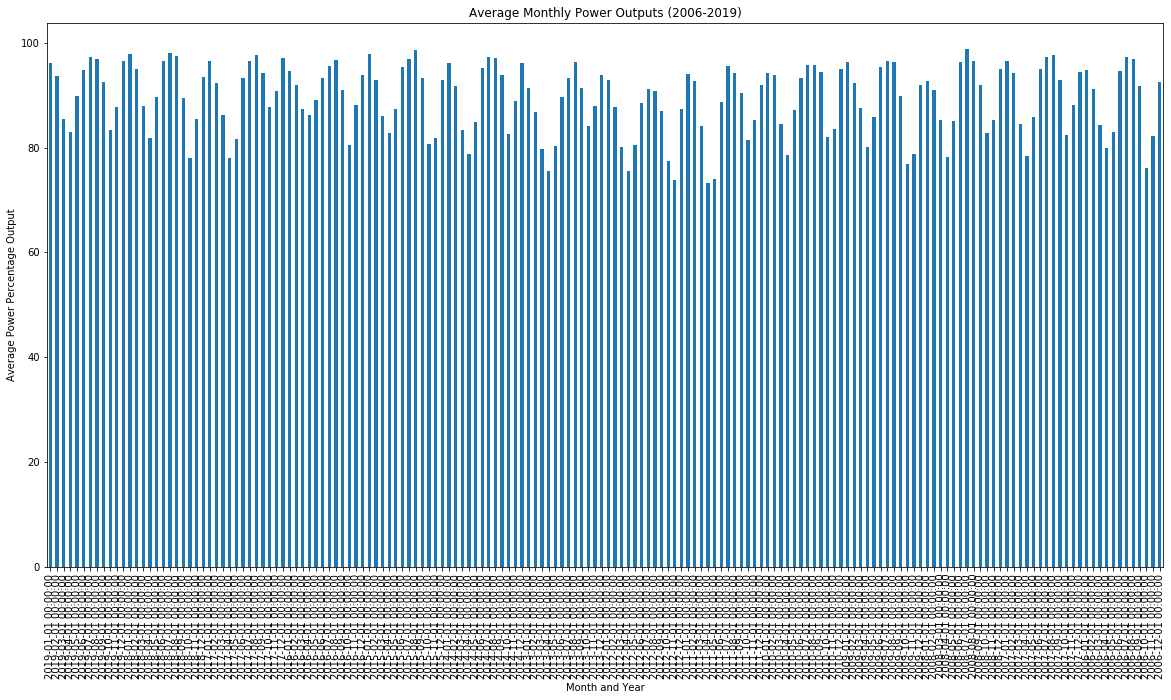

In [106]:
powerplot = df.Avg_Power.plot(x = 'Year', y= 'Avg_Power', kind = 'bar', figsize = (20,10))
powerplot.set_xlabel("Month and Year")
powerplot.set_ylabel("Average Power Percentage Output")
powerplot.set_title("Average Monthly Power Outputs (2006-2019)");

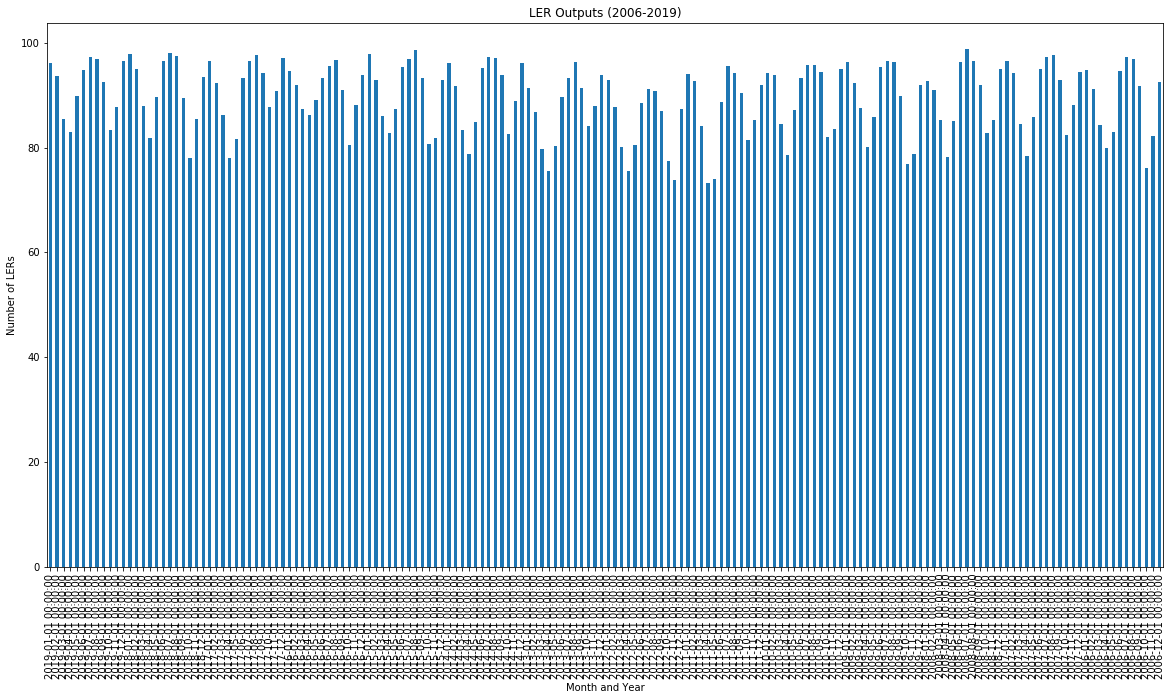

In [107]:
powerplot = df.Avg_Power.plot(x = 'Year', y= 'LER', kind = 'bar', figsize = (20,10))
powerplot.set_xlabel("Month and Year")
powerplot.set_ylabel("Number of LERs")
powerplot.set_title("LER Outputs (2006-2019)");

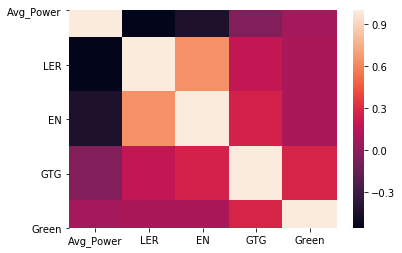

In [108]:
sns.heatmap(df.corr());

LERs and ENs have high correlation together, which is expected, as there is some repetition in what they submit to the NRC.  LER has the strongest negative correlation with Avg_Power, although it is not very strong.  Next is EN.  GTG barely has any correlation and is likely 0.  Green has a slightly higher correlation.  

Correlations are weak with Avg_Power.

## Model Building 

In [109]:
feature_cols = ['LER', 'EN', 'GTG', 'Green'] #going to start out using all columns, then I will remove GTG
X = df[feature_cols]

y = df.Avg_Power

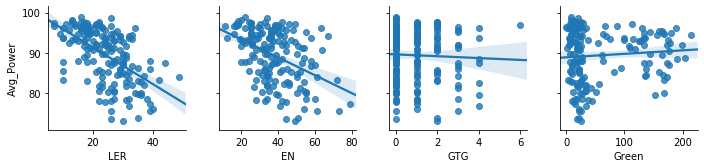

In [110]:
sns.pairplot(df,
            x_vars=feature_cols,
            y_vars = 'Avg_Power',
            kind = 'reg');

In [111]:
#instantiate model
linreg = LinearRegression()
#fit to selected variables
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))


y intercept is:100.75462755795033
slope coeff is:[-0.39126475 -0.07759945  0.27182361  0.01435207]


### 80/20 Train Test Split - Better than 70/30 and 90/10 

70/30

In [112]:
linreg = LinearRegression()
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))
#70/30 tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=60)
   
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:100.75462755795033
slope coeff is:[-0.39126475 -0.07759945  0.27182361  0.01435207]
root mean squared error is:  5.4504239085242645
mean squared error is:  29.707120782612918
r2 score is: 0.08251481927023607


90/10

In [113]:
linreg = LinearRegression()
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))
#70/30 tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=60)
   
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:100.75462755795033
slope coeff is:[-0.39126475 -0.07759945  0.27182361  0.01435207]
root mean squared error is:  6.010641719538477
mean squared error is:  36.12781388065647
r2 score is: -0.057744891251453774


80/20

In [63]:
#split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
#instantiate linear regression model   
linreg = LinearRegression()
#fit training data to model using training data
linreg.fit(X_train, y_train)
#perform prediction using test data
y_pred = linreg.predict(X_test)

###  Evaluate Model

In [64]:
#report the scores   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

root mean squared error is:  5.377267245109486
mean squared error is:  28.915003025327362
r2 score is: 0.07438157520121447


In [65]:
#compare the actual values to predicted values
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df2

,Actual,Predicted
Year,,
2018-04-01,81.826599,86.389623
2018-10-01,78.011404,87.986932
2014-03-01,83.374333,80.363625
2007-05-01,85.859936,90.180384
2015-05-01,87.420202,86.455922
2015-09-01,93.369558,90.936533
2010-05-01,87.145192,86.456237
2006-11-01,82.178050,86.690554
2008-04-01,78.190650,89.359968


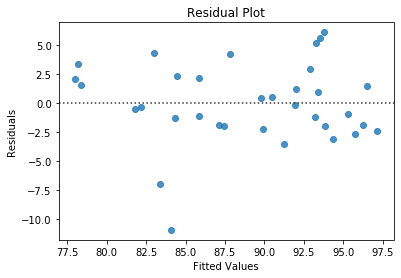

In [66]:
#Plot the residuals
sns.residplot(y_test, y_pred, data = df)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot');

Remove the GTG variable from the feature_cols as it had no impact

In [67]:
#Removing GTG from the feature_cols
feature_cols = ['LER', 'EN', 'Green'] 
X = df[feature_cols]

y = df.Avg_Power

In [68]:
linreg = LinearRegression()
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))
#70/30 tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
   
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:100.71680673144856
slope coeff is:[-0.39047235 -0.07182969  0.01568717]
root mean squared error is:  5.371399034856913
mean squared error is:  28.851927591661777
r2 score is: 0.07640072711006596


Including or removing GTG makes no difference

Test only with the 'EN' variable

In [69]:
#test only with EN
feature_cols = ['EN'] 
X = df[feature_cols]

y = df.Avg_Power

In [70]:
linreg = LinearRegression()
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))
#70/30 tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
   
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:97.75005818767468
slope coeff is:[-0.22096073]
root mean squared error is:  6.038298438569198
mean squared error is:  36.461048033227215
r2 score is: -0.16718015963778532


In [73]:
feature_cols = ['LER'] 
X = df[feature_cols]

y = df.Avg_Power

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
   
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

root mean squared error is:  5.366928480546119
mean squared error is:  28.803921315297075
r2 score is: 0.07793748966444747


Using only LER, we can predict slightly better than including EN, GTG, and Green.  This makes some sense because whenever there is a scram (sudden decrease in power), the plant has to submit an LER.  But ENs can include
lots of items that do not result in any significant decrease in power.

## Alternate Approach 

Alternatively, I attempted to look at this information per each nuclear plant to see if it is possible to predict the power output for a specific plant.  

Challenges: There is not enough data per month, or even quarter, to be able to make an accurate prediction.  In fact, per year, at many plants the average number of the different events were under 10.  

Therefore, I decided to look at the predicting the annual average power output of a specific plant relative to the number of LERs, ENs, GTGs, and Greens that year.  I selected three plants: Waterford, Seabrook, and Harris.

In [83]:
df_alt = pd.read_excel('PowerStatusProjData_2.xlsx')

In [84]:
df_alt.head()

,Site,Year,Green,GTG,EN,LER,PowerAvg
0,Waterford,2006,6,0,3,1,90.85
1,Waterford,2007,16,0,0,0,95.97
2,Waterford,2008,14,0,1,6,86.97
3,Waterford,2009,18,1,3,3,87.14
4,Waterford,2010,7,0,5,4,99.98


In [85]:
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
Site        42 non-null object
Year        42 non-null int64
Green       42 non-null int64
GTG         42 non-null int64
EN          42 non-null int64
LER         42 non-null int64
PowerAvg    42 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 2.4+ KB


In [86]:
df_alt.describe()

,Year,Green,GTG,EN,LER,PowerAvg
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,2012.500000,8.309524,0.166667,4.880952,3.071429,90.151429
std,4.079993,5.598293,0.437101,6.169170,1.904972,7.318146
min,2006.000000,0.000000,0.000000,0.000000,0.000000,73.830000
25%,2009.000000,5.000000,0.000000,2.000000,2.000000,86.940000
50%,2012.500000,7.000000,0.000000,4.000000,3.000000,89.870000
75%,2016.000000,10.750000,0.000000,5.000000,4.000000,97.015000
max,2019.000000,24.000000,2.000000,35.000000,7.000000,100.000000


The correlations per site are worse as there is less data to work with.

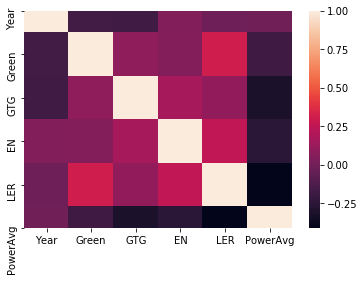

In [87]:
sns.heatmap(df_alt.corr())

In [89]:
Waterford = df_alt.loc[df_alt.Site == 'Waterford']
Seabrook = df_alt.loc[df_alt.Site == 'Seabrook']
Harris = df_alt.loc[df_alt.Site == 'Harris']

Waterford

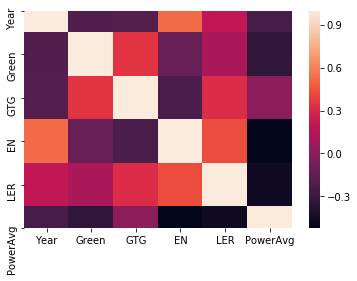

In [90]:
sns.heatmap(Waterford.corr());

In [94]:
feature_cols = ['LER', 'EN', 'GTG', 'Green'] 
X = Waterford[feature_cols]

y = Waterford.PowerAvg

#instantiate model
linreg = LinearRegression()
#fit to selected variables
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))

#split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
#instantiate linear regression model   
linreg = LinearRegression()
#fit training data to model using training data
linreg.fit(X_train, y_train)
#perform prediction using test data
y_pred = linreg.predict(X_test)
#report the scores   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:105.07007907112978
slope coeff is:[-1.10152297 -1.43137606  2.66784046 -0.53036332]
root mean squared error is:  7.273204028260263
mean squared error is:  52.899496836701324
r2 score is: -0.9163599020530386


At Waterford, the RMSE is ~7%

Seabrook

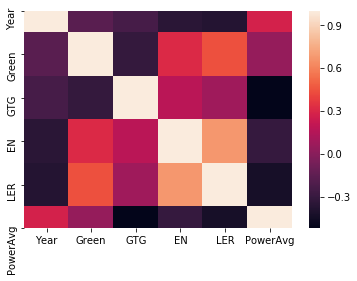

In [91]:
sns.heatmap(Seabrook.corr());

In [95]:
feature_cols = ['LER', 'EN', 'GTG', 'Green'] 
X = Seabrook[feature_cols]

y = Seabrook.PowerAvg

#instantiate model
linreg = LinearRegression()
#fit to selected variables
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))

#split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
#instantiate linear regression model   
linreg = LinearRegression()
#fit training data to model using training data
linreg.fit(X_train, y_train)
#perform prediction using test data
y_pred = linreg.predict(X_test)
#report the scores   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:94.60852931771764
slope coeff is:[-2.60990787  0.4434349  -6.86167119  0.28680099]
root mean squared error is:  11.059593153718712
mean squared error is:  122.31460072578182
r2 score is: -0.37962663231572447


At Seabrook, the RMSE is ~ 11%

Harris

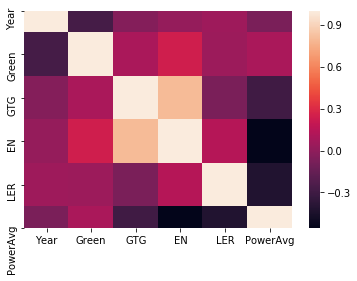

In [93]:
sns.heatmap(Harris.corr());

In [97]:
feature_cols = ['LER', 'EN', 'GTG', 'Green'] 
X = Harris[feature_cols]

y = Harris.PowerAvg

#instantiate model
linreg = LinearRegression()
#fit to selected variables
linreg.fit(X, y)

print('y intercept is:{}'.format(linreg.intercept_))
print('slope coeff is:{}'.format(linreg.coef_))

#split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)
#instantiate linear regression model   
linreg = LinearRegression()
#fit training data to model using training data
linreg.fit(X_train, y_train)
#perform prediction using test data
y_pred = linreg.predict(X_test)
#report the scores   
print("root mean squared error is: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mean squared error is: ", mean_squared_error(y_test, y_pred))
print('r2 score is:', linreg.score(X_test, y_test))

y intercept is:95.10900721482223
slope coeff is:[-0.87755386 -0.45624621  6.59274023  0.36869145]
root mean squared error is:  5.575301504804432
mean squared error is:  31.08398686947456
r2 score is: 0.020701936903125828


At Harris, the RMSE is ~5.6%.

It makes sense that Harris would provide the lowest RMSE because between the 3 sites, it had the highest number of LERs and ENs.  

##  